In [1]:
import pandas as pd
import geopandas as gd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import rasterio
import rasterio.warp
from rasterio import features
import shapely.geometry
import shapely
import seaborn as sn

In [2]:
os.chdir('/projects/canis/eoc_feature_corr')

In [3]:
grid_path = "./data/by_state/ME/me_extent_coverage.shp"
grid = gd.read_file(grid_path)
grid = grid.set_index('id')

In [4]:
feature_path = './data/cover/NLCD_2016_Land_Cover_L48_20190424_3857.tiff'

feature_file = rasterio.open(feature_path)
feature_raster = feature_file.read(1)

In [5]:
feature_legend_path = './data/cover/NLCD_landcover_legend_2018_12_17_IGrpwzCAkFkyZtKBIu8z.csv'
feature_legend = pd.read_csv(feature_legend_path)
feature_legend = feature_legend.set_index('Value')
feature_legend = feature_legend.dropna()

In [6]:
feature_legend

,Legend
Value,
0,Unclassified
11,Open Water
12,Perennial Snow/Ice
21,"Developed, Open Space"
22,"Developed, Low Intensity"
23,"Developed, Medium Intensity"
24,"Developed, High Intensity"
31,Barren Land
41,Deciduous Forest


In [7]:
grid['centroid'] = grid['geometry'].centroid
grid = grid.set_geometry('centroid')
grid['feature'] = grid['centroid'].map(lambda coords: next(feature_file.sample(coords.coords, indexes=1))[0])
grid = grid.set_geometry('geometry')
grid = grid.drop('centroid', axis=1)
grid

,left,top,right,bottom,med_rxpwr,chg_covera,verizon_co,geometry,feature
id,,,,,,,,,
462.0,-7.855368e+06,5.525930e+06,-7.854368e+06,5.524930e+06,-96.055,1,1,"POLYGON ((-7855367.514 5525929.661, -7854367.5...",41
463.0,-7.855368e+06,5.524930e+06,-7.854368e+06,5.523930e+06,-102.590,1,1,"POLYGON ((-7855367.514 5524929.661, -7854367.5...",41
464.0,-7.855368e+06,5.523930e+06,-7.854368e+06,5.522930e+06,-99.260,1,1,"POLYGON ((-7855367.514 5523929.661, -7854367.5...",41
467.0,-7.855368e+06,5.520930e+06,-7.854368e+06,5.519930e+06,-84.250,1,1,"POLYGON ((-7855367.514 5520929.661, -7854367.5...",22
1001.0,-7.854368e+06,5.523930e+06,-7.853368e+06,5.522930e+06,-95.550,1,1,"POLYGON ((-7854367.514 5523929.661, -7853367.5...",41
...,...,...,...,...,...,...,...,...,...
206582.0,-7.471368e+06,5.613930e+06,-7.470368e+06,5.612930e+06,-120.540,0,0,"POLYGON ((-7471367.514 5613929.661, -7470367.5...",71
207118.0,-7.470368e+06,5.614930e+06,-7.469368e+06,5.613930e+06,-117.160,0,0,"POLYGON ((-7470367.514 5614929.661, -7469367.5...",42
207119.0,-7.470368e+06,5.613930e+06,-7.469368e+06,5.612930e+06,-123.710,0,0,"POLYGON ((-7470367.514 5613929.661, -7469367.5...",11


In [8]:
grid = grid.join(feature_legend, how="left", on='feature')

In [9]:
grid['agreement'] = grid['chg_covera'] == grid['verizon_co']

In [10]:
sn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [11]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], normalize='index')
print (confusion_matrix)

Agreement                         False     True 
Cover Type                                       
Barren Land                    0.604651  0.395349
Cultivated Crops               0.417204  0.582796
Deciduous Forest               0.576949  0.423051
Developed, High Intensity      0.444444  0.555556
Developed, Low Intensity       0.507143  0.492857
Developed, Medium Intensity    0.453333  0.546667
Developed, Open Space          0.581633  0.418367
Emergent Herbaceuous Wetlands  0.548387  0.451613
Evergreen Forest               0.584383  0.415617
Hay/Pasture                    0.526576  0.473424
Herbaceuous                    0.512346  0.487654
Mixed Forest                   0.596294  0.403706
Open Water                     0.541096  0.458904
Shrub/Scrub                    0.642857  0.357143
Unclassified                   0.333333  0.666667
Woody Wetlands                 0.585209  0.414791


In [12]:
confusion_matrix['Total'] = grid.groupby('Legend').count()['agreement']

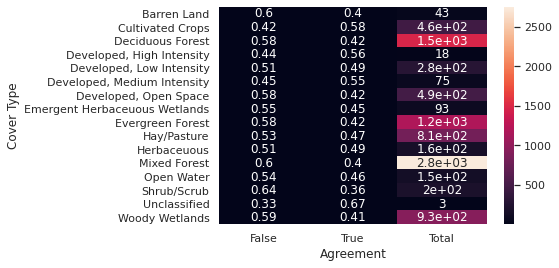

In [13]:
sn.heatmap(confusion_matrix, annot=True)
plt.show()

Agreement                      False  True   All
Cover Type                                      
Barren Land                       26    17    43
Cultivated Crops                 194   271   465
Deciduous Forest                 851   624  1475
Developed, High Intensity          8    10    18
Developed, Low Intensity         142   138   280
Developed, Medium Intensity       34    41    75
Developed, Open Space            285   205   490
Emergent Herbaceuous Wetlands     51    42    93
Evergreen Forest                 696   495  1191
Hay/Pasture                      426   383   809
Herbaceuous                       83    79   162
Mixed Forest                    1641  1111  2752
Open Water                        79    67   146
Shrub/Scrub                      126    70   196
Unclassified                       1     2     3
Woody Wetlands                   546   387   933
All                             5189  3942  9131


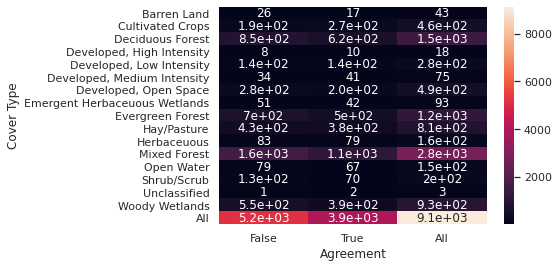

In [14]:
confusion_matrix = pd.crosstab( grid['Legend'],grid['agreement'], rownames=['Cover Type'], colnames=['Agreement'], margins=True)
print (confusion_matrix)
sn.heatmap(confusion_matrix, annot=True)
plt.show()